In [1]:
import pandas as pd
import dask
from dask import dataframe as daskdataframe
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Union


def plot_sentence_lengths(
    df: pd.DataFrame,
    text_col: str = 'text',
    label_col: str = 'label_text',
    word_count_col='sentence_length',
    figsize: tuple = (14, 6),
    bins: int = 30,
    rotation: int = 45,
    log_scale: bool = False,
    palette: Optional[str] = None,
    show_stats: bool = True
) -> None:
    
    """
    Plots sentence length distributions by class and overall.
    
    Args:
        df: Input DataFrame containing text and labels
        text_col: Name of column containing text (default 'text')
        label_col: Name of column containing class labels (default 'label_text')
        figsize: Figure size (default (14, 6))
        bins: Number of bins for histograms (default 30)
        rotation: X-tick rotation for class labels (default 45)
        log_scale: Whether to use log scale for y-axis (default False)
        palette: Color palette for plots (default None)
        show_stats: Whether to print length statistics (default True)
    """
    # Calculate sentence lengths
    if isinstance(df, dask.dataframe.DataFrame):
        df = df.sample(frac=0.1).compute()
        
    if word_count_col == 'sentence_length':
        df = df.copy()
        df['sentence_length'] = df[text_col].apply(lambda x: len(str(x).split()))
    
    if show_stats:
        print("Sentence Length Statistics:")
        if isinstance(df, dask.dataframe.DataFrame):
            print(df.groupby(label_col)['sentence_length'].describe(meta=('description', 'object')))
        else:
            print(df.groupby(label_col)['sentence_length'].describe())
            
    
    # Set up figure
    plt.figure(figsize=figsize)
    
    # Plot 1: Overall distribution
    plt.subplot(1, 2, 1)
    sns.histplot(
        data=df,
        x=word_count_col,
        bins=bins,
        kde=True,
        color='skyblue' if palette is None else None,
        palette=palette
    )
    plt.title('Overall Sentence Length Distribution')
    plt.xlabel('Number of Words')
    if log_scale:
        plt.yscale('log')
        plt.ylabel('Frequency (log scale)')
    else:
        plt.ylabel('Frequency')
    
    # Plot 2: By-class distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df,
        x=label_col,
        y=word_count_col,
        palette=palette
    )
    plt.title('Sentence Length by Class')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Words')
    plt.xticks(rotation=rotation)
    if log_scale:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

    # Additional facet plot
    plt.figure(figsize=(12, 8))
    g = sns.FacetGrid(
        df,
        col=label_col,
        col_wrap=3,
        height=4,
        sharex=False,
        palette=palette
    )
    g.map(sns.histplot, word_count_col, bins=bins, kde=True)
    g.set_titles('{col_name}')
    g.fig.suptitle('Sentence Length Distribution by Class', y=1.02)
    plt.tight_layout()
    plt.show()

def draw_dist_binary_judgement(_df:Union[daskdataframe.DataFrame, pd.DataFrame],text):

    # Draw the distribution of binary_judgement
    plt.figure(figsize=(8, 6))
    if isinstance(_df, dask.dataframe.DataFrame):
        class_counts = _df['label_text'].value_counts().compute()
    else:
        class_counts = _df['label_text'].value_counts()
    print(class_counts.to_dict())
    class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(text)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()
  

def plot_label_distribution(df, figsize=(12, 6), name: str = "", label_column: str = 'label_text'):
    """
    Plot the distribution of labels in the dataset with count annotations.
    
    Parameters:
        df: DataFrame containing the data
        figsize: Tuple specifying figure size (default: (12, 6))
        name: Optional name to include in title (default: "")
        label_column: Name of the column containing labels (default: 'label')
    """
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-v0_8-deep')
    
    # Create count plot
    ax = sns.countplot(data=df, x=label_column, order=df[label_column].value_counts().index)
    
    plt.title(f'Label Distribution {name}', pad=20)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add exact counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')

    plt.show()
    


# get random 900 points
def read_data_frame_statistic(path:str):
    df_small = pd.read_csv(path)
    plot_label_distribution(df_small,name=path)
    mean =df_small["text"].apply(lambda x: len(x.split())).mean()
    print(f"Mean text length: {mean}")
    print(f"Max text length: {df_small['text'].apply(lambda x: len(x.split())).max()}")
    print(f"Min text length: {df_small['text'].apply(lambda x: len(x.split())).min()}")
    print(df_small.describe())


In [2]:
import pandas as pd

splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
df_train = pd.read_json("hf://datasets/SetFit/ag_news/" + splits["train"],lines=True)

In [3]:
df_train

,text,label,label_text
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business
...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,World
119996,Renteria signing a top-shelf deal Red Sox gene...,1,Sports
119997,Saban not going to Dolphins yet The Miami Dolp...,1,Sports
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,Sports


In [4]:
df_train.to_csv("../data/raw/agnews/train.csv",index=False)

In [6]:
df_test = pd.read_json("hf://datasets/SetFit/ag_news/" + splits["test"],lines=True)
df_test.to_csv("../data/raw/agnews/test.csv",index=False)

In [3]:
df_tets = pd.read_csv("../data/raw/agnews/test.csv")

In [4]:
df_tets['label_text'].unique()

array(['Business', 'Sci/Tech', 'Sports', 'World'], dtype=object)

# AG-NEWS TRAIN

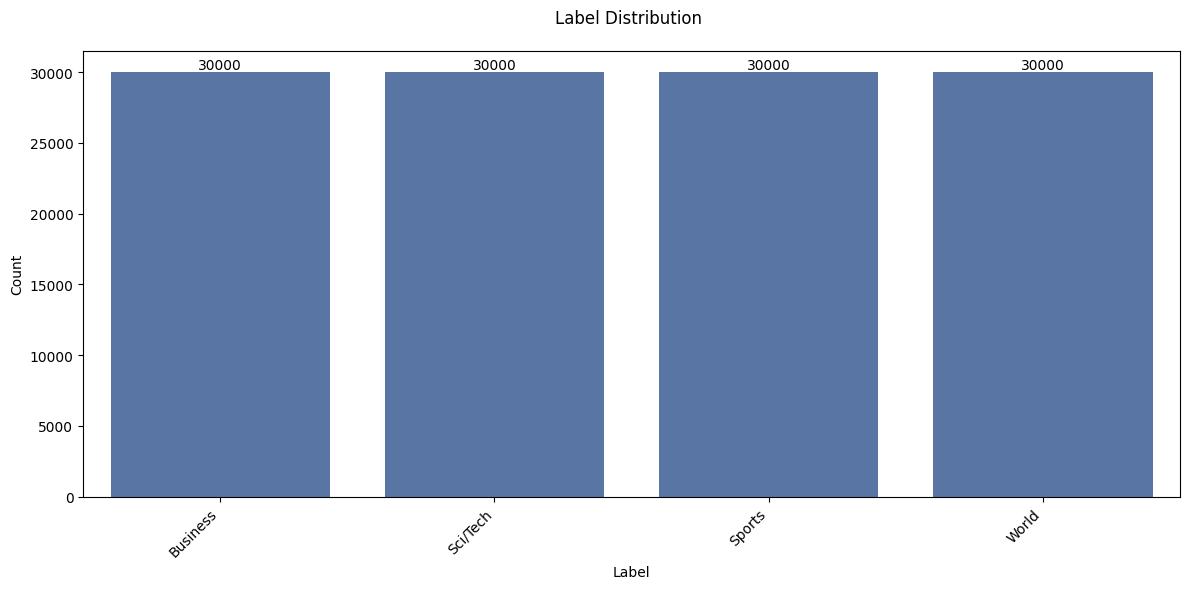

In [8]:
plot_label_distribution(df_train)

Sentence Length Statistics:
              count       mean        std   min   25%   50%   75%    max
label_text                                                              
Business    30000.0  37.538233   8.121983   8.0  32.0  37.0  42.0  134.0
Sci/Tech    30000.0  37.191967  12.417603   8.0  30.0  36.0  42.0  177.0
Sports      30000.0  37.774733   8.870100   8.0  32.0  37.0  42.0  151.0
World       30000.0  38.884867  10.315517  11.0  33.0  39.0  44.0  145.0


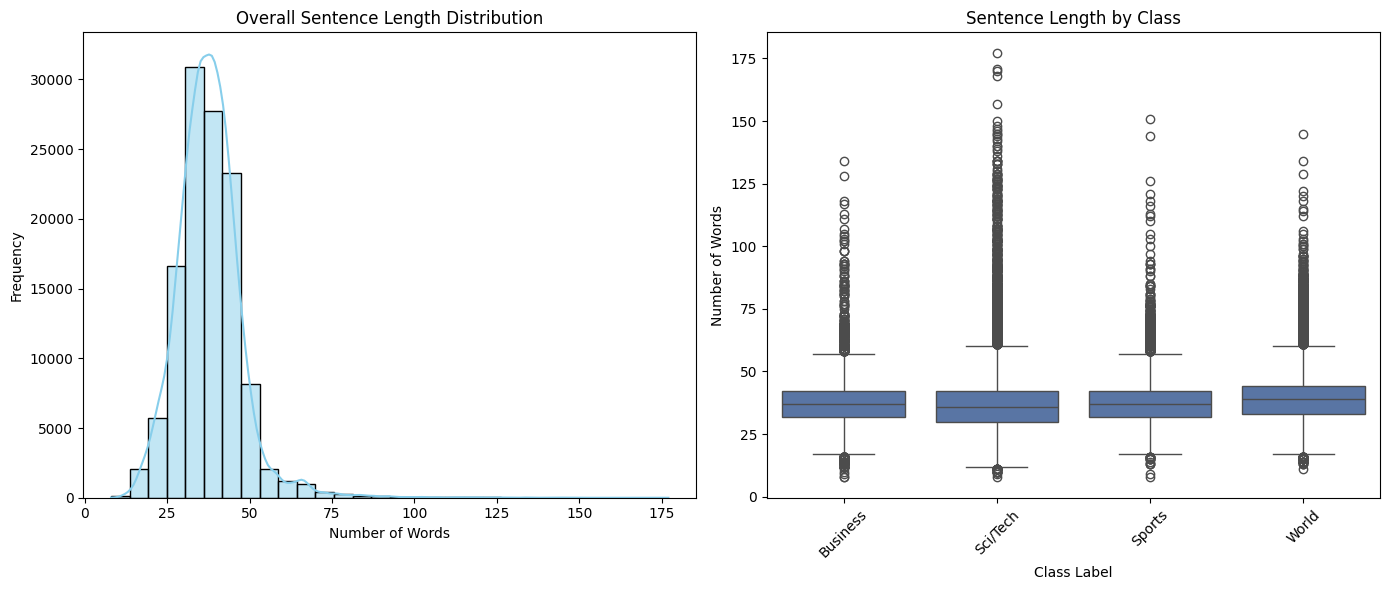

<Figure size 1200x800 with 0 Axes>

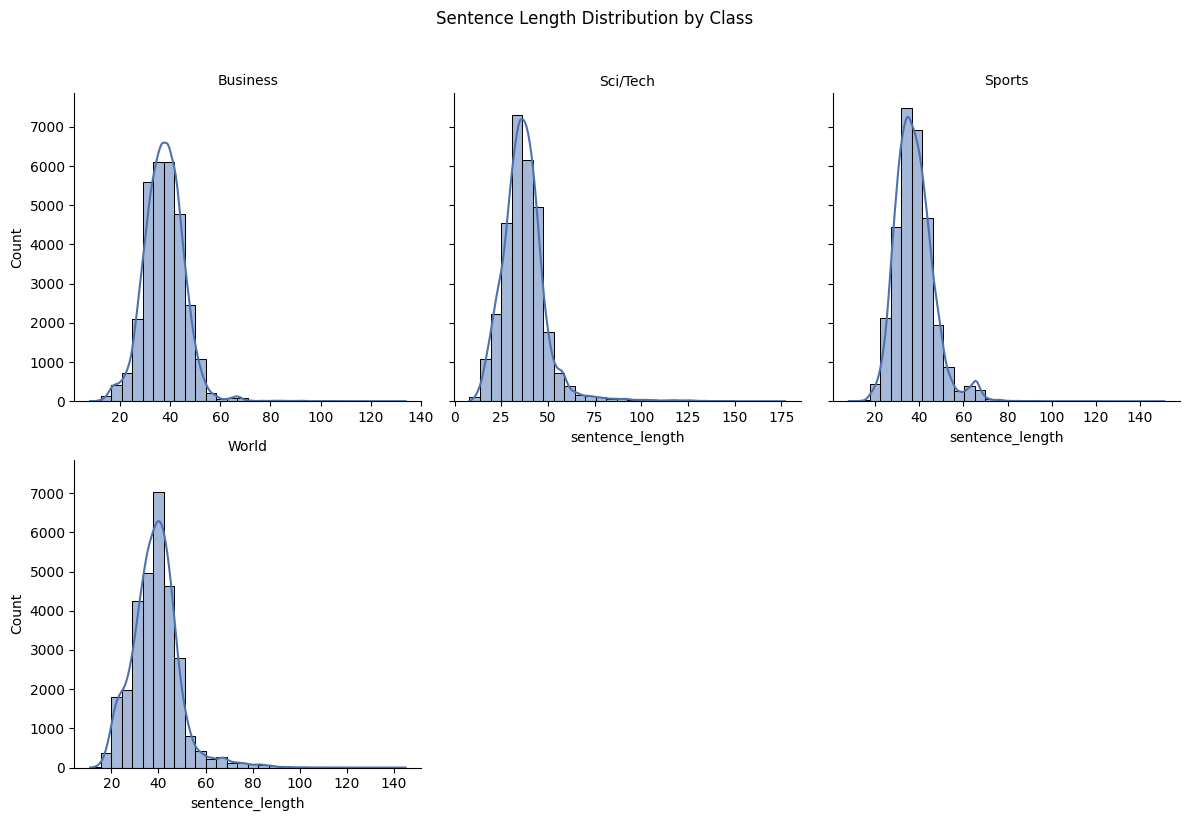

In [9]:
plot_sentence_lengths(df_train)

# Test

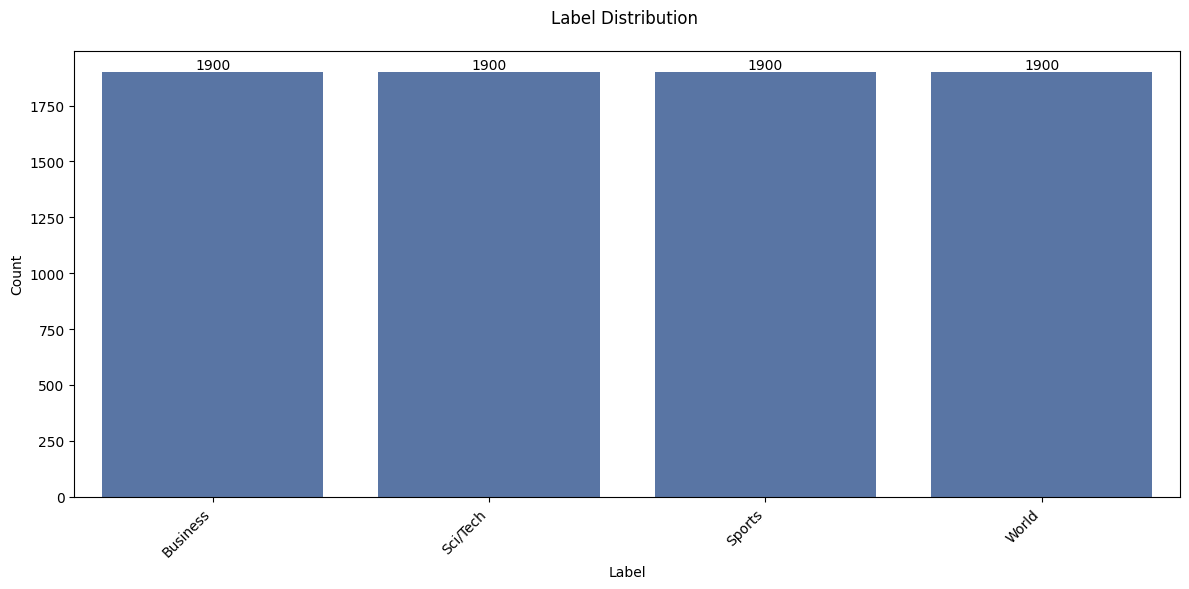

In [10]:
plot_label_distribution(df_test)

Sentence Length Statistics:
             count       mean        std   min   25%   50%   75%    max
label_text                                                             
Business    1900.0  37.627895   8.058956  14.0  33.0  37.0  42.0  126.0
Sci/Tech    1900.0  37.148947  12.902740  11.0  30.0  36.0  42.0  137.0
Sports      1900.0  37.565263   8.718490  17.0  32.0  37.0  42.0   90.0
World       1900.0  38.547368  10.106196  15.0  32.0  39.0  44.0  106.0


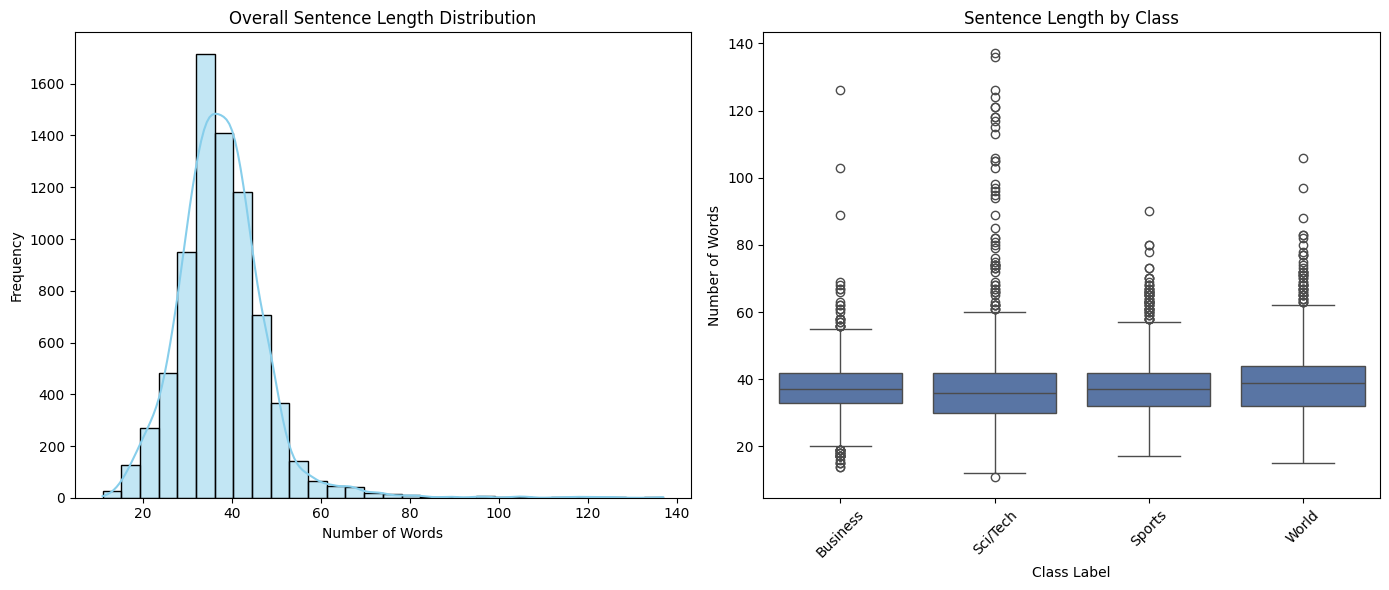

<Figure size 1200x800 with 0 Axes>

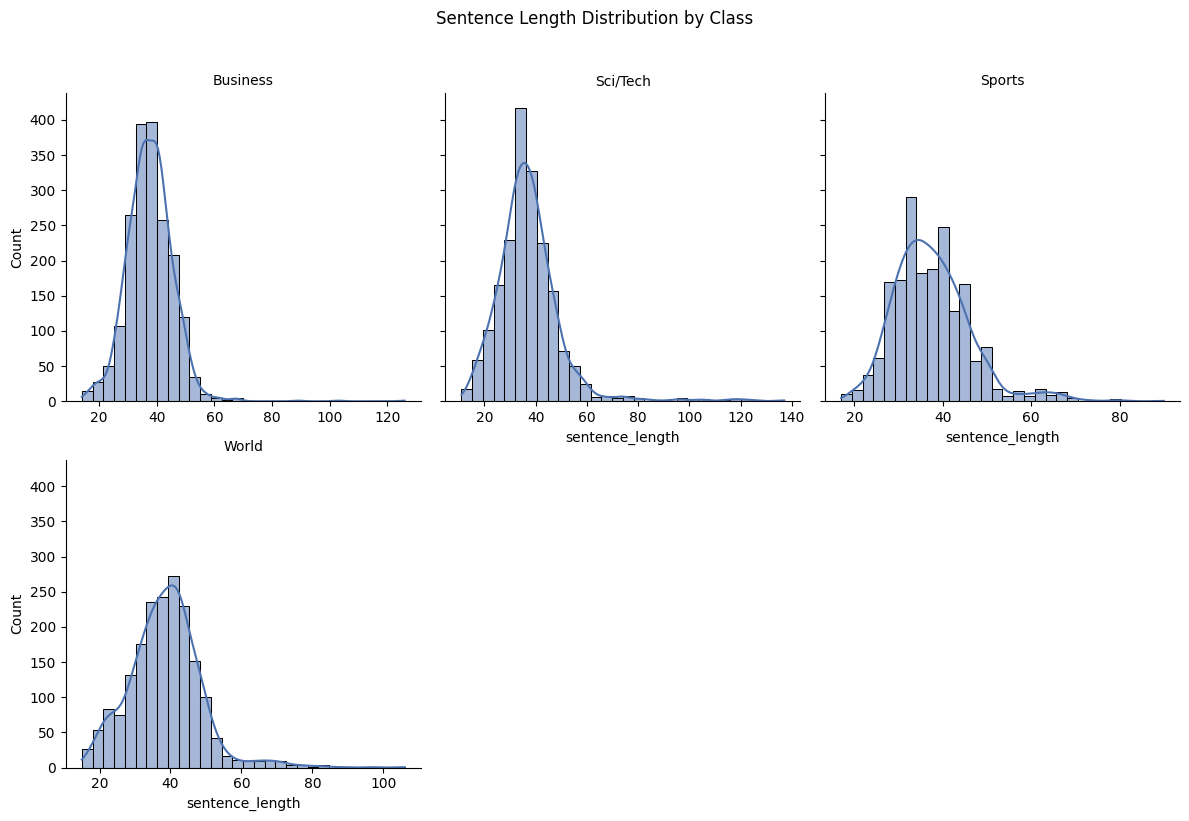

In [11]:
plot_sentence_lengths(df_test)